<a href="https://colab.research.google.com/github/shravanc/tf/blob/master/windowed_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [34]:
path = "https://raw.githubusercontent.com/shravanc/datasets/master/nov_time_series.csv"
df = pd.read_csv(path)
series = df['series'].values
time = list(range(0, len(series)))
df.head(5)

,series
0,3557.033333
1,2848.983333
2,1294.080556
3,19.422222
4,0.000000


# EDA

In [7]:
df.describe()

,series
count,720.000000
mean,319.332445
std,675.243077
min,0.000000
25%,0.000000
50%,0.000000
75%,156.057173
max,3816.338889


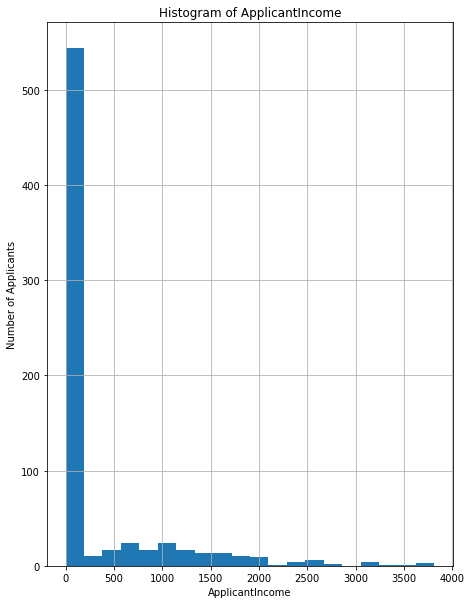

In [15]:
fig = plt.figure(figsize=(16,10))

# Plot ApplicantIncome
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Histogram of ApplicantIncome")
ax1.set_xlabel('ApplicantIncome')
ax1.set_ylabel('Number of Applicants')
df['series'].hist(bins=20)

In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

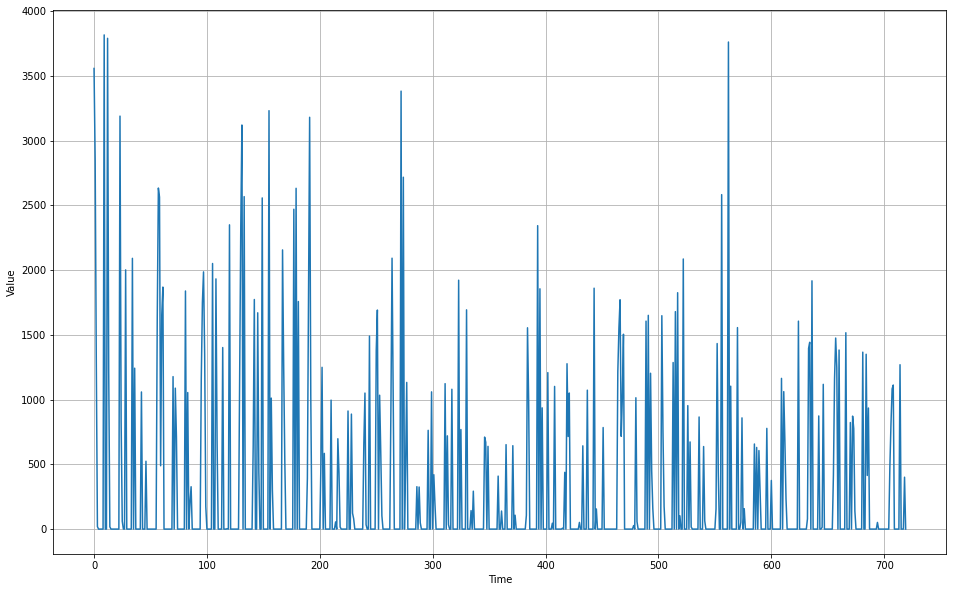

In [17]:
plt.figure(figsize=(16,10))
plot_series(time, series)

# Preprocessing

In [0]:
def split_data(df):
  tr = df.sample(frac=0.8, random_state=0)
  te = df.drop(tr.index)

  return tr, te

def normalize(df):
  copy = df.copy()
  series = copy['series'].values
  mean = copy['series'].mean()
  std =  copy['series'].std()
  copy['series'] = (series-mean) / std

  return copy

def windowed_dataset(dataset, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(dataset)
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

# Data Prep

In [9]:
tr_data, te_data = split_data(df)
print(tr_data.tail())
norm_tr_data = normalize(tr_data)
norm_te_data = normalize(te_data)

window_size = 24
batch_size  = 32
shuffle_buffer = 500

tr_dataset = windowed_dataset(norm_tr_data['series'].values, window_size, batch_size, shuffle_buffer)
te_dataset = windowed_dataset(norm_te_data['series'].values, window_size, batch_size, shuffle_buffer)

          series
25     60.455556
110     0.000000
149  2557.380556
152     0.000000
528   673.116667


# Modeling

In [0]:
def build_model():
  l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
  model = tf.keras.models.Sequential([l0])
  return l0, model

# Compilation

In [19]:
l0, model = build_model()
model.summary()

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
history = model.fit(tr_dataset, epochs=100,verbose=0)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 25        
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


# Prediction

In [20]:
d = "3557.033333,2848.9833329999997,1294.0805560000001,19.42222222,0.0,0.0,0.0,0.0,0.0,3816.338889,0.0,0.0,3789.961111,1224.0777779999999,17.77777778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3189.275".split(',')
pr_data = [float(s) for s in d]
print(pr_data)
model.predict([pr_data])

[3557.033333, 2848.9833329999997, 1294.0805560000001, 19.42222222, 0.0, 0.0, 0.0, 0.0, 0.0, 3816.338889, 0.0, 0.0, 3789.961111, 1224.0777779999999, 17.77777778, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3189.275]


array([[814.8525]], dtype=float32)

**Expected**: 830.3509749 </br>
**Prediction**: 814.8525 </br>